## Content
1. Imports and data exploration - (you can skip this)
2. Create the dataset - per each timeframe (each 10 seconds) a matrix of shape 40 (channels) * 9 (features) gets extracted. Resulting in 6 matrices per video per participant (60 seconds in total) and 240 matrices in total per participant ie. 40 videos * 6 matrices.
3. Extract Labels - here I reconstructed the binary labels, every label gets rounded to 0 if <=5 or 1 if >5
4. Normalize Data - not done yet cause I'm not sure how to do it or if needed at all.

## 1. Imports and data exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew,kurtosis
import pandas as pd
from numpy.fft import fft, ifft

In [2]:
#this is a dict
raw_data = np.load('data/data_preprocessed_python/s01.dat',allow_pickle=True,encoding='bytes')

In [3]:
raw_data.keys()

dict_keys([b'labels', b'data'])

In [4]:
data = raw_data[b'data']
labels = raw_data[b'labels']

In [5]:
#valance, arousal, dominance, liking
labels[0]

array([7.71, 7.6 , 6.9 , 7.83])

In [6]:
data.shape #shape of data in (video/trial x channel x data) 40 layers, 40 rows, and 8064 columns

(40, 40, 8064)

In [7]:
data[0][0][0] #check an element

0.948231680995192

In [8]:
labels.shape #shape of the labels

(40, 4)

In [9]:
# experiment 1 first eeg channel
data[0][0]
# experiment 1 second eeg channel
# data[b'data'][0][1] 

array([ 0.94823168,  1.65333533,  3.01372577, ..., -2.82648937,
       -4.47722969, -3.67692812])

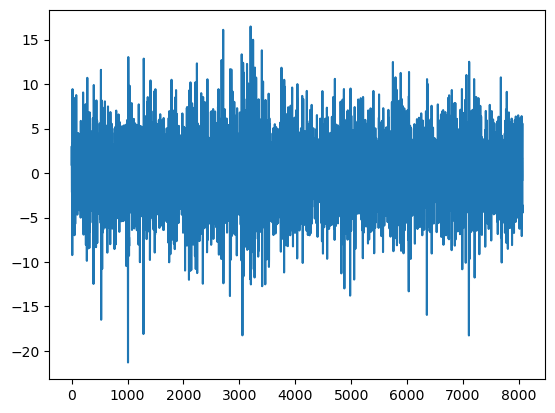

In [10]:
visu = data[0][0]
plt.plot(visu)

/opt/anaconda3/envs/BSc/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


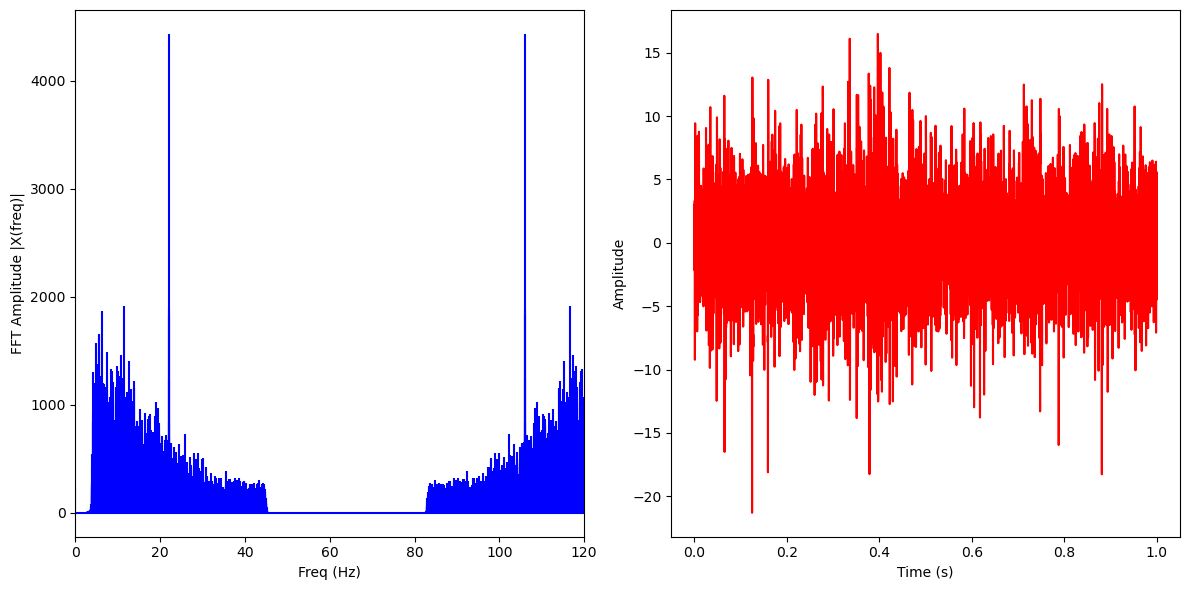

In [11]:
sr = 128
X = fft(visu)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 120)

plt.subplot(122)
t = np.arange(0,1,(1/8064))
plt.plot(t, ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [17]:
len(np.abs(freq))

8064

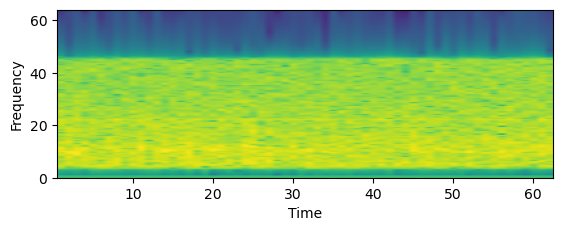

In [47]:
# Plot the spectrogram
import matplotlib.image as mpimg

plt.subplot(212)
visu = data[0][8]
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(visu, Fs=128)

plt.xlabel('Time')

plt.ylabel('Frequency')

 
#fig.imsave("out1.png", bbox_inches='tight', pad_inches=0)
plt.show()   

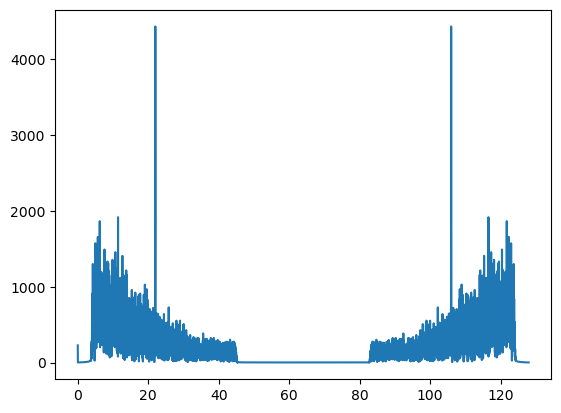

In [12]:
plt.plot(freq, np.abs(fft(visu)))

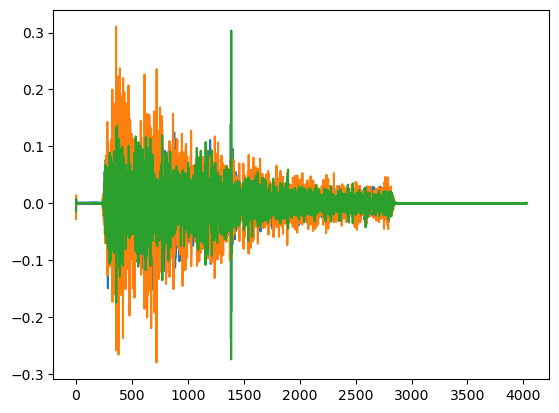

In [22]:
from scipy import signal
f, t, Zxx = signal.stft(visu, fs=1.0, nperseg=8064)
plt.plot(Zxx)

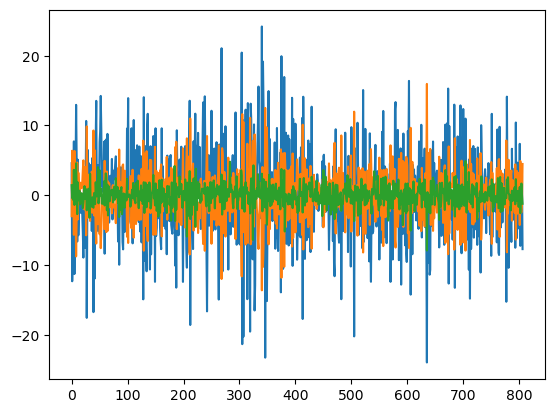

In [30]:
import tensorflow as tf
sign = tf.signal.stft(
    visu,
    frame_length = 4,
    frame_step = 10,
    fft_length=None,
    window_fn=tf.signal.hann_window,
    pad_end=False,
    name=None
)
plt.plot(sign)

In [32]:
visu.shape

(8064,)

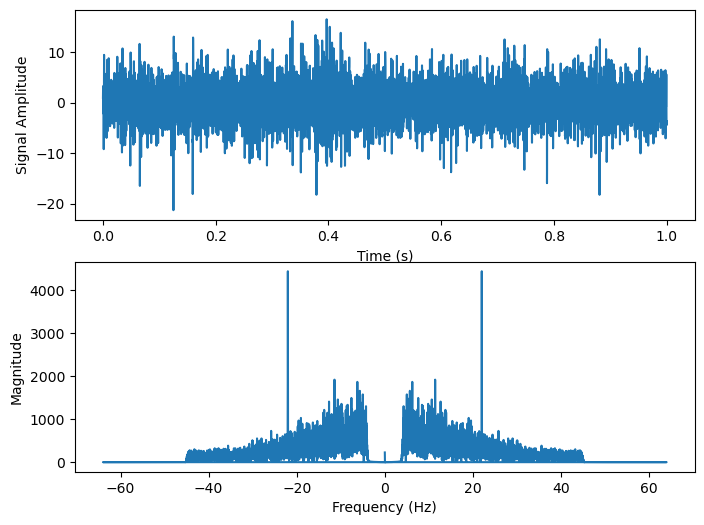

In [11]:
# Perform FFT
fft = np.fft.fft(visu)

# Calculate corresponding frequencies
freqs = np.fft.fftfreq(len(visu), d=1/128)

# Plot the signal in time and frequency domain
t = np.arange(0,1,(1/8064))
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(t, visu)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal Amplitude')
ax[1].plot(freqs, np.abs(fft))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Magnitude')

plt.show()

In [12]:
freqs.shape

(8064,)

In [13]:
np.abs(fft).shape

(8064,)

In [14]:
len(freqs)

8064

In [15]:
# theta = 4-7
# alpha = 8-12
# beta = 13-30
# gamma = 30-50
theta = []
alpha = []
beta = []
gamma = []
for i in range(len(freqs)):
    if freqs[i] > 4 and freqs[i] < 7:
        theta.append(np.abs(fft[i]))
    if freqs[i] > 8 and freqs[i] < 12:
        alpha.append(np.abs(fft[i]))
    if freqs[i] > 13 and freqs[i] < 30:
        beta.append(np.abs(fft[i]))
    if freqs[i] > 30 and freqs[i] < 50:
        gamma.append(np.abs(fft[i]))

In [16]:
np.max(np.abs(fft))

4435.394133600661

In [17]:
np.mean(beta)

335.0955724314887

In [18]:
print(np.mean(theta))
print(np.mean(alpha))
print(np.mean(beta))
print(np.mean(gamma))

697.9565305512332
595.6951706857623
335.0955724314887
110.31530628353664


## 2. Create the dataset 

In [135]:
raw_data = np.load('data/data_preprocessed_python/s01.dat',allow_pickle=True,encoding='bytes')[b'data']
raw_data.shape

(40, 40, 8064)

In [136]:
# Loads the saved numpy files that are saved into a dictionary
def loadfiles():
    num_testsub = 32
    data_dict = {}
    print("Loading files into data_dict .................")
    for i in range(num_testsub):
                    if i < 10:
                        name = '%0*d' % (2,i+1)
                    else:
                        name = i+1
                    fname = 'data/data_prepared/data_preprocessed_python/'+str(name) +'.npy'
    #                 print(fname)
                    raw_data = np.load('data/data_preprocessed_python/s01.dat',allow_pickle=True,encoding='bytes')[b'data']
                    data_dict["sub%s" %name] = raw_data
    print("Loaded!!!!!") 
    return data_dict

In [137]:
data_dict = loadfiles()

Loading files into data_dict .................
Loaded!!!!!


In [139]:
data_dict['sub01'].shape

(40, 40, 8064)

In [140]:
def get_bands(fft,frequency):
    #t = np.arange(0,1,(1/8064))
    theta = []
    alpha = []
    beta = []
    gamma = []
    for i in range(len(frequency)):
        if frequency[i] > 4 and frequency[i] < 7:
            theta.append(np.abs(fft[i]))
        if frequency[i] > 8 and frequency[i] < 12:
            alpha.append(np.abs(fft[i]))
        if frequency[i] > 13 and frequency[i] < 30:
            beta.append(np.abs(fft[i]))
        if frequency[i] > 30 and frequency[i] < 50:
            gamma.append(np.abs(fft[i]))
    return np.mean(theta), np.std(theta), np.mean(alpha), np.std(alpha), np.mean(beta), np.std(beta), np.mean(gamma), np.std(gamma)

In [141]:
num_participants = 32
num_videos = 40
num_channels = 40

df = pd.DataFrame()

data = []
for sub in data_dict.keys():
    for i in range(num_videos):
        fo = []
        for j in range(32): # 32 channels are only EEG
            visu = data_dict[sub][i][j]
            # Perform FFT
            fft = np.fft.fft(visu)
            # Calculate corresponding frequencies
            freqs = np.fft.fftfreq(len(visu), d=1/128)
            theta, tst, alpha, ast, beta, bst, gamma, gst = get_bands(fft,freqs)
            fo.append([theta,tst,alpha,ast,beta,bst,gamma,gst])
        df['p:'+str(sub)+' v:'+str(i)] = fo

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['p:'+str(sub)+' v:'+str(i)] = fo
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_20071/910543736.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

In [142]:
df

,p:sub01 v:0,p:sub01 v:1,p:sub01 v:2,p:sub01 v:3,p:sub01 v:4,p:sub01 v:5,p:sub01 v:6,p:sub01 v:7,p:sub01 v:8,p:sub01 v:9,...,p:sub32 v:30,p:sub32 v:31,p:sub32 v:32,p:sub32 v:33,p:sub32 v:34,p:sub32 v:35,p:sub32 v:36,p:sub32 v:37,p:sub32 v:38,p:sub32 v:39
0,"[697.9565305512332, 350.98412381999674, 595.69...","[782.474223556193, 422.0629290449065, 670.9004...","[758.1173426578182, 419.5792944419964, 667.708...","[757.3737280685644, 405.3228406746923, 588.807...","[548.3339286274108, 302.69905752509436, 591.94...","[703.9131411112039, 360.4128854352002, 608.648...","[771.9374241669123, 371.8124275867568, 700.544...","[878.5651547692755, 482.8720631335891, 734.208...","[881.9060496128575, 485.13397803944576, 730.55...","[698.5949796645766, 357.7190922922264, 669.859...",...,"[556.1688414557757, 296.3168118560032, 573.307...","[729.2015692020984, 432.62442882659514, 718.60...","[812.8305786898028, 413.98866228172574, 643.94...","[648.0490107402605, 387.1854529398391, 630.145...","[676.2587020649576, 337.3064804427725, 585.808...","[690.0578450977569, 384.1428130280834, 703.724...","[825.2765393044515, 451.9861836471442, 705.072...","[704.9172818274502, 374.8480779699984, 748.680...","[666.0356139607776, 328.03121757567504, 625.33...","[595.2655474405882, 311.37599193860905, 552.09..."
1,"[805.0353791616049, 437.82266368144866, 629.72...","[957.0668281787889, 495.2752586340881, 696.976...","[881.3284198017736, 481.34991277839725, 691.27...","[935.2126335469694, 523.8181528316528, 595.817...","[580.882280088457, 354.4330669312347, 595.2477...","[805.5004888897597, 389.9687165216128, 616.365...","[906.3253650193445, 449.54950566112666, 725.84...","[1018.8038145357516, 599.0716632511992, 768.62...","[1093.0325697425264, 625.441820508129, 757.269...","[804.2825424058196, 407.10489455763013, 674.71...",...,"[674.4164293052669, 343.53339318256764, 557.18...","[832.8539305816156, 472.15712031425824, 711.52...","[991.7895045299995, 561.6191228252494, 679.607...","[803.8638335094921, 465.0559382671794, 645.820...","[805.0088719390794, 408.86362179572467, 597.30...","[872.1187943548987, 513.3593287428813, 720.501...","[964.5723244837457, 550.9925593804111, 730.744...","[783.2272091717846, 427.32643276900495, 773.15...","[703.5756111426037, 367.23832692949543, 639.97...","[663.2261526204855, 361.4397619359235, 579.836..."
2,"[846.9386399049897, 481.30540834532405, 668.88...","[1019.9953129700062, 505.2959778756564, 691.60...","[961.7181177956669, 513.1343173111549, 705.794...","[1024.45183378665, 525.2812605418187, 616.5260...","[592.2245170187674, 352.73487567501235, 600.02...","[851.5057213642239, 425.82723199738035, 630.40...","[945.5363361607331, 489.87114723172004, 761.45...","[1064.5138693007586, 577.0972843796496, 799.53...","[1180.4093543137592, 641.6042457207984, 777.75...","[841.9912728618953, 421.07295685955296, 670.14...",...,"[725.1703603013123, 387.9458384925307, 565.633...","[883.248656447899, 472.089584059226, 718.73637...","[1043.3996507669133, 580.4228879642785, 689.64...","[903.5896530749853, 492.9002762734935, 694.542...","[859.046236326312, 494.93382794110335, 617.931...","[935.1743821212672, 508.83596764373976, 732.77...","[1039.6354929706115, 592.3879796991397, 751.73...","[836.8713301433426, 438.58854409377216, 776.11...","[788.5122061962098, 378.6802637185745, 655.802...","[725.4385868086756, 373.4015903176599, 598.812..."
3,"[859.6629389646537, 460.7869396607902, 700.799...","[1039.597773703373, 518.0448697857994, 785.021...","[1065.3899571198492, 536.7408611625992, 816.98...","[1006.5333921814154, 530.2811694992142, 729.38...","[651.4545841137824, 349.19228655034163, 663.09...","[885.2503537279899, 445.1278214449818, 705.847...","[1027.5925775781607, 534.897887839633, 772.299...","[1097.138129131844, 592.4923278280247, 929.769...","[1208.0685760996532, 633.2866834921914, 918.67...","[891.4617310569436, 462.6003121436924, 739.179...",...,"[775.7450838953039, 408.99748682329204, 671.27...","[898.9296911300963, 493.6312

In [143]:
df.iloc[0,0]

[697.9565305512332,
 350.98412381999674,
 595.6951706857623,
 307.6870354431414,
 335.0955724314887,
 252.49911871204623,
 110.31530628353664,
 88.67947665110836]

In [144]:
data.shape

AttributeError: 'list' object has no attribute 'shape'

In [145]:
df.to_csv('data.csv', index=False)

## 3. Extract Labels - same as before

In [22]:
def turn_into_binary(recorded_value):
    if recorded_value <= 5: 
        return 0
    else:
        return 1

In [23]:
# 0 = Valance; 1 = Arousal; 2 = Dominance; 3 = Liking
index = [0, 1, 2, 3]

for ind in index: 
    binary_labels = []
    for i in range(num_testsub):

                if i < 10:
                    name = '%0*d' % (2,i+1)
                else:
                    name = i+1
                # Read in labels of file
                labels = np.load('data/data_preprocessed_python/s'+str(name)+'.dat',allow_pickle=True,encoding='bytes')[b'labels']
                # Temp variable
                rounded_labels = np.empty(40)
                # round the values and save them
                for j in range(labels.shape[0]):
                    binary_value = turn_into_binary(labels[j][ind])
                    rounded_labels[j] = binary_value
                # Append to global list
                binary_labels = np.append(binary_labels, rounded_labels,axis=0) 

    np.save('data/data_prepared/labels/label_class_'+str(ind)+'.npy', binary_labels)            
            

In [28]:
binary_labels.shape

(1280,)

In [ ]:
#Load the labels now    
valence = np.load('data/data_prepared/labels/label_class_0.npy')
arousal = np.load('data/data_prepared/labels/label_class_1.npy')
dominance = np.load('data/data_prepared/labels/label_class_2.npy')
liking = np.load('data/data_prepared/labels/label_class_3.npy')

In [ ]:
test = arousal[440:480]
print(len(test))
print(test)

In [ ]:
labels2 = np.load('data/data_preprocessed_python/s12.dat',allow_pickle=True,encoding='bytes')[b'labels']
labels2

## 4. Normalize Data 

In [146]:
df = pd.read_csv('data.csv')

In [147]:
df.iloc[0,0]

'[697.9565305512332, 350.98412381999674, 595.6951706857623, 307.6870354431414, 335.0955724314887, 252.49911871204623, 110.31530628353664, 88.67947665110836]'

In [148]:
import ast
ast.literal_eval(df.iloc[0,0])[2]

595.6951706857623

In [149]:
df.shape[1]

1280

In [150]:
df_norm = df.copy()
for i in range(df.shape[0]):
    theta = []
    t_std = []
    alpha = []
    a_std = []
    beta = []
    b_std = []
    gamma = []
    g_std = []
    for j in range(df.shape[1]):
        theta.append(ast.literal_eval(df.iloc[i,j])[0])
        t_std.append(ast.literal_eval(df.iloc[i,j])[1])
        alpha.append(ast.literal_eval(df.iloc[i,j])[2])
        a_std.append(ast.literal_eval(df.iloc[i,j])[3])
        beta.append(ast.literal_eval(df.iloc[i,j])[4])
        b_std.append(ast.literal_eval(df.iloc[i,j])[5])
        gamma.append(ast.literal_eval(df.iloc[i,j])[6])
        g_std.append(ast.literal_eval(df.iloc[i,j])[7])
        
    theta_min, theta_max = np.min(theta), np.max(theta)
    t_std_min, t_std_max = np.min(t_std), np.max(t_std) 
    alpha_min, alpha_max = np.min(alpha), np.max(alpha)
    a_std_min, a_std_max = np.min(a_std), np.max(a_std)
    beta_min, beta_max = np.min(beta), np.max(beta)
    b_std_min, b_std_max = np.min(b_std), np.max(b_std)
    gamma_min, gamma_max = np.min(gamma), np.max(gamma)
    g_std_min, g_std_max = np.min(g_std), np.max(g_std)
    
    
    new_theta = (theta - theta_min) / (theta_max - theta_min)
    new_t_std = (t_std - t_std_min) / (t_std_max - t_std_min)
    new_alpha = (alpha - alpha_min) / (alpha_max - alpha_min)
    new_a_std = (a_std - a_std_min) / (a_std_max - a_std_min)
    new_beta = (beta - beta_min) / (beta_max - beta_min)
    new_b_std = (b_std - b_std_min) / (b_std_max - b_std_min)
    new_gamma = (gamma - gamma_min) / (gamma_max - gamma_min)
    new_g_std = (g_std - g_std_min) / (g_std_max - g_std_min)
    
    #print(new_theta)
    for j in range(df.shape[1]):
        df_norm.iloc[i,j] = [new_theta[j], new_t_std[j], new_alpha[j], new_a_std[j], new_beta[j], new_b_std[j], new_gamma[j], new_g_std[j]]


In [151]:
df_norm

,p:sub01 v:0,p:sub01 v:1,p:sub01 v:2,p:sub01 v:3,p:sub01 v:4,p:sub01 v:5,p:sub01 v:6,p:sub01 v:7,p:sub01 v:8,p:sub01 v:9,...,p:sub32 v:30,p:sub32 v:31,p:sub32 v:32,p:sub32 v:33,p:sub32 v:34,p:sub32 v:35,p:sub32 v:36,p:sub32 v:37,p:sub32 v:38,p:sub32 v:39
0,"[0.4485464836863576, 0.23743089577886559, 0.25...","[0.7019180566921461, 0.5461401369897261, 0.551...","[0.6288997216273957, 0.5353532230667453, 0.539...","[0.6266704748094754, 0.47343463832216404, 0.22...","[0.0, 0.027719349129351294, 0.2419823433081025...","[0.4664035232446203, 0.27838186329410847, 0.30...","[0.6703302868325047, 0.32789231857853357, 0.66...","[0.9899844902094569, 0.810246175123128, 0.8003...","[1.0, 0.8200701167617226, 0.7860376730186085, ...","[0.4504604599247114, 0.26668218946707795, 0.54...",...,"[0.023487912614575716, 0.0, 0.1688471178401590...","[0.5422144993423434, 0.5920108093137332, 0.739...","[0.7929219302890472, 0.5110720072159004, 0.446...","[0.2989311031697405, 0.39466039348987386, 0.39...","[0.383499595408718, 0.1780261984830269, 0.2179...","[0.42486739015137676, 0.38144560948409556, 0.6...","[0.8302330838047564, 0.6761027213858244, 0.686...","[0.4694137889505188, 0.3410767456862581, 0.857...","[0.3528522856935695, 0.13774190624327134, 0.37...","[0.14069406842073867, 0.06540498312891915, 0.0..."
1,"[0.4376705502296044, 0.254018240277233, 0.2693...","[0.7345198385896154, 0.4087973258721663, 0.518...","[0.5866366685377687, 0.3712820091155642, 0.497...","[0.6918483902407707, 0.4856927745072331, 0.143...","[0.0, 0.02936406157968117, 0.14132115411848697...","[0.4385787010938146, 0.1250982116934351, 0.219...","[0.6354445003842665, 0.28561071891161105, 0.62...","[0.8550645060517051, 0.6884280824623885, 0.784...","[1.0, 0.7594701099040868, 0.7428377621977087, ...","[0.43620059742279504, 0.17126361064875048, 0.4...",...,"[0.18263027690560762, 0.0, 0.0, 0.0, 0.1178004...","[0.49198771451120754, 0.3465163390385843, 0.57...","[0.8023176648383595, 0.5875297685548204, 0.454...","[0.4353830465890147, 0.32738553276610755, 0.32...","[0.43761879350299326, 0.17600167677000353, 0.1...","[0.5686543972535026, 0.4575163756832502, 0.606...","[0.749174709350357, 0.5589014746654936, 0.6443...","[0.39508896738104143, 0.22574106630170537, 0.8...","[0.23956509160039643, 0.06386183204540176, 0.3...","[0.16078068136532242, 0.04824031680822762, 0.0..."
2,"[0.43305115456159876, 0.33820919608068983, 0.2...","[0.7272727360986004, 0.4013172120922402, 0.324...","[0.628193005579958, 0.42193623282761633, 0.360...","[0.7348494713934763, 0.45388918362867675, 0.13...","[0.0, 0.0, 0.08854355459381283, 0.242177251600...","[0.4408158590722382, 0.1922719503295613, 0.166...","[0.600681616967235, 0.36074166602101265, 0.504...","[0.8029607741233296, 0.5901930115923396, 0.602...","[1.0, 0.7598807859499533, 0.546100683704346, 0...","[0.42463990910031324, 0.17976566651074732, 0.2...",...,"[0.22602732143513016, 0.0926236454061902, 0.0,...","[0.4947834778732565, 0.3139666541989151, 0.394...","[0.7670635234717356, 0.5989411258878955, 0.319...","[0.5293661385223014, 0.36870989386269004, 0.33...","[0.4536358341616443, 0.3740592212739289, 0.134...","[0.5830647839881333, 0.4106292765966895, 0.430...","[0.7606639062806281, 0.6304157100918507, 0.479...","[0.41593525982356744, 0.22584101950439925, 0.5...","[0.333717696770545, 0.068250233159693, 0.23213...","[0.22648334561385075, 0.054364501723285136, 0...."
3,"[0.3740623804802889, 0.3928083563481559, 0.160...","[0.6973291997292141, 0.5943537959674001, 0.449...","[0.7436668480597128, 0.660162877660154, 0.5590...","[0.6379264861826297, 0.6374250421627957, 0.258...","[0.0, 0.0, 0.031795570390553814, 0.0, 0.001354...","[0.4200321461199312, 0.33768893694259255, 0.17...","[0.6757609382444814, 0.6536756912080274, 0.405...","[0.8007048896273071, 0.8564056310039908, 0.945...","[1.0, 1.0, 0.907485307279899, 0.78238725106086...","[0.4311913649293486, 0.39919134912246734, 0.29...",...,"[0.2232974764757198, 0.21051172045885758, 0.05...","[0.44460813163064694, 0.5084

In [152]:
te =[]
for j in range(df.shape[1]):
    te.append(ast.literal_eval(df.iloc[0,j])[0])

In [128]:
te

[20.07664917848284,
 30.421658015430914,
 21.18241582719397,
 8.101035388821279,
 8.925034483674999,
 24.068631669875508,
 22.728961151650203,
 14.280386531682481,
 16.939369263371287,
 38.609708525410525,
 53.81752210711497,
 21.615398085821088,
 59.69395502161472,
 36.60555405046311,
 46.88831088267089,
 19.91075820879388,
 9.209396237010264,
 22.724021158536768,
 24.32292960943672,
 105.993586112563,
 21.297524187816684,
 16.21123444794241,
 24.900319662154427,
 12.257831286594667,
 22.46614954094475,
 136.13547786698078,
 34.96414938373393,
 21.110395543745163,
 22.77357658693547,
 43.12311584417285,
 16.90118171412513,
 23.453213963794045,
 17.66618071841107,
 22.486095039366575,
 39.004459456414665,
 19.315594117312656,
 53.36450411587252,
 33.780183454807606,
 14.770966046434758,
 21.311780511463347,
 1535.0309179984465,
 1919.0889212638192,
 5967.238258081787,
 4462.74929561104,
 5828.598637031375,
 2421.845154071474,
 1704.0124333470303,
 2864.158176967277,
 1345.5903193618674

In [153]:
print(np.max(te))
print(np.min(te))
print(te[0])

881.9060496128575
548.3339286274108
697.9565305512332


(array([ 64.,  64., 128., 128., 256., 128., 192., 160.,  64.,  96.]),
 array([548.33392863, 581.69114073, 615.04835282, 648.40556492,
        681.76277702, 715.11998912, 748.47720122, 781.83441332,
        815.19162542, 848.54883751, 881.90604961]),
 <BarContainer object of 10 artists>)

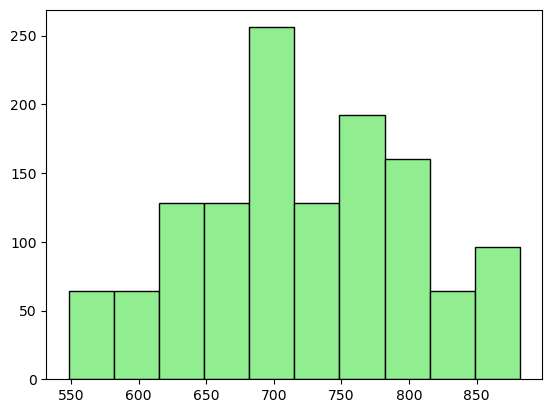

In [154]:
plt.hist(te, color='lightgreen', ec='black')

In [155]:
df_norm.to_csv('data_norm.csv', index=False)

In [49]:
value = df_norm.iloc[0,0]

In [89]:
array_of_lists = df_norm.iloc[:,0].values
#np.concatenate(array_of_lists).flatten()
np.concatenate(array_of_lists, axis=0).reshape(32, 4)

(32, 4)

In [95]:
array_of_lists = df_norm.iloc[:,0].values
values = np.concatenate(array_of_lists, axis=0).reshape(32, 4)
tra = np.multiply(values, 255).astype(np.uint8)
tra
#img = Image.fromarray(tra)

array([[114,  65,  45,  22],
       [111,  68,  29,   8],
       [110,  67,  20,   8],
       [ 95,  41,  27,   9],
       [ 84,  44,   8,   9],
       [ 84,  71,  21,  14],
       [ 86, 122,  24,  13],
       [ 83,  42,  50,  46],
       [ 70, 113,  46,  30],
       [ 37,  81,  91,  18],
       [ 88,  67,  81,  71],
       [ 87,  90,  81,  89],
       [ 91,  62, 101, 146],
       [119,  76, 145, 190],
       [123,  82,  80,  77],
       [ 95,  71, 171,  33],
       [ 98,  31,  70,  36],
       [ 76,  63,  56,  64],
       [ 62,  94,  53,  33],
       [ 85,  50,  70,  34],
       [105,  85,  50,  21],
       [ 63,  80,  15,  12],
       [ 60,  79,  42,  28],
       [ 13,  13,  19,  17],
       [ 88,  73,  56,  26],
       [103,  87,  13,  25],
       [ 56,  94,  30,  21],
       [ 88,  11, 138,  30],
       [107,  34,  73,  49],
       [ 88,  65,  34,  37],
       [118,  48,  62,  35],
       [122,  46,  47,  18]], dtype=uint8)

In [64]:
for i in range(df_norm.shape[1]):
    df_norm.iloc[:,i]

0     [0.4485464836863576, 0.2567182871303501, 0.180...
1     [0.4376705502296044, 0.2693243020354921, 0.116...
2     [0.43305115456159876, 0.26581349522442765, 0.0...
3     [0.3740623804802889, 0.16097329232868013, 0.10...
4     [0.3313692905345566, 0.17475936389882238, 0.03...
5     [0.3313703815518914, 0.2787144507998754, 0.086...
6     [0.3379621593436653, 0.4808589789482433, 0.095...
7     [0.3264616745975952, 0.16471522421666263, 0.19...
8     [0.27670094633064035, 0.44620127951940824, 0.1...
9     [0.14597026890170606, 0.3200987988646987, 0.36...
10    [0.3486952965846812, 0.2638539505931325, 0.319...
11    [0.34200770098607636, 0.35380389521553934, 0.3...
12    [0.3583237749000568, 0.24672675142737022, 0.39...
13    [0.46717204420089714, 0.29873027792287177, 0.5...
14    [0.4842129385034698, 0.3243236139597703, 0.316...
15    [0.37454686702674067, 0.281440742076121, 0.673...
16    [0.3881421834000899, 0.12327163403465573, 0.27...
17    [0.30003663264619923, 0.24768620438449282,

In [157]:
from PIL import Image
for i in range(5):
    array_of_lists = df_norm.iloc[:,i].values
    values = np.concatenate(array_of_lists, axis=0).reshape(32, 8)
    tra = np.multiply(values, 255).astype(np.uint8)
    img = Image.fromarray(tra)
    display(img)
    img.save("test04"+str(i)+".png")

In [60]:
counter = 0
for i in range(880):
    for j in range(32):
        value = df_norm.iloc[j,i]
        tra = np.multiply(value, 255).astype(np.uint8)
        #print(tra)
        img = Image.fromarray(tra)
        #display(img)
        #img.save("image/train"+str(counter)+".png")